In [1]:
# DESCRIPTION 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6


In [3]:
# Read the files
item_df = pd.read_csv("data/items.csv")
categories_df = pd.read_csv("data/category_trans.csv")
shops_df = pd.read_csv("data/shop_trans.csv")
sales_df = pd.read_csv("data/sales_train.csv")

In [4]:
# change the dateformat
sales_df["date"] = pd.to_datetime(sales_df["date"], infer_datetime_format=True)

In [5]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [6]:
# get the aggreate monthly sales
monthly_sales = sales_df.groupby(['date_block_num', 'shop_id', 'item_id'])['date', 'item_price','item_cnt_day'].agg({"date": ['min', 'max'], 'item_cnt_day':'sum', 'item_price':'mean'})

In [7]:
monthly_sales.head()

date            item_cnt_day item_price
                                      min        max          sum       mean
date_block_num shop_id item_id                                              
0              0       32      2013-01-21 2013-03-01          6.0      221.0
                       33      2013-01-17 2013-03-01          3.0      347.0
                       35      2013-01-31 2013-01-31          1.0      247.0
                       43      2013-01-31 2013-01-31          1.0      221.0
                       51      2013-01-13 2013-01-31          2.0      128.5

### Time Series Analysis
- We are required to to predict the next month sales per given item id and shop id

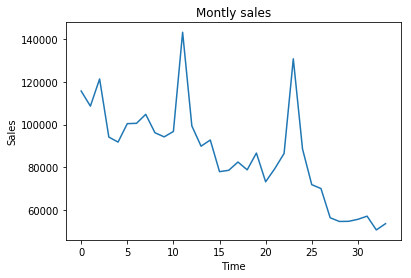

In [17]:
# get the monthly sales of all the items
ts = sales_df.groupby(["date_block_num"])["item_cnt_day_sum"].count()
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title("Montly sales")
plt.plot(ts)

In [31]:
ts.head()

date_block_num
0    115690
1    108613
2    121347
3     94109
4     91759
Name: item_cnt_day_sum, dtype: int64

#### 1. Check if tha data is stationary 
A Time Series is said to be stationary if the mean, variance **remains constant** over time.

We use two methods to check the stationary of the data:-
    1. ADCF(Augmented Dicky Fuller Test) Test:-
        In this case, if the **Test Statistics** is less than the **Critical Value**, the data is stationary.
    2. Rolling statistics

In [38]:
from statsmodels.tsa.stattools import adfuller
def test_stationary(timeseries_df):

    # determining rolling statictics
    rolmean = timeseries_df.rolling(window=12).mean() # window 12, monthly
    rolstd = timeseries_df.rolling(window=12).std()
    
    # ploting rolling
    origi = plt.plot(timeseries_df, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling mean")
    std = plt.plot(rolstd, color="black", label="Rolling std")
    plt.legend(loc='best')
    plt.title("rolling statistics")
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print("results of ADFC test")
    dftest = adfuller(timeseries_df, autolag="AIC")
    print(dftest)
    dfoutput = pd.Series(dftest[0:4], index=["Test statistics", "p-value", "#lags Used", "Number of observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Critical value (%s)" %key] = value
    print(dfoutput)

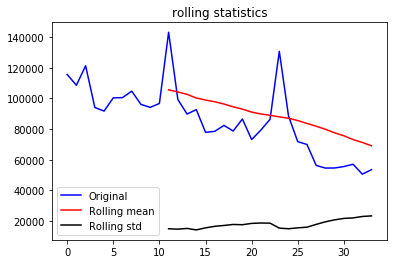

results of ADFC test
Test statistics                -2.342877
p-value                         0.158512
#lags Used                      0.000000
Number of observations Used    33.000000
Critical value (1%)            -3.646135
Critical value (5%)            -2.954127
Critical value (10%)           -2.615968
dtype: float64


In [24]:
test_stationary(ts)

The test statistics is not less than any of the critical values, therefore we can conclude that the data **is not** stationary

#### Make the data Stationary

###### 1.0 Eliminate trend
  **Differencing** - Take the difference in a particular time lag

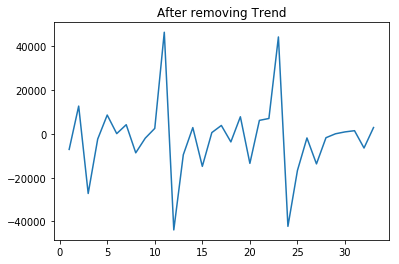

In [41]:
ts_shift = ts - ts.shift()
plt.title("After removing Trend")
plt.plot(ts_shift)


We can use the above function or create a differencing function

In [42]:
from pandas import Series as Series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval] # get the difference of the data at and index and the previous index
        diff.append(value)
    return Series(diff)

# inverse the difference
def inverse_difference(last_ob, value):
    return value + last_ob

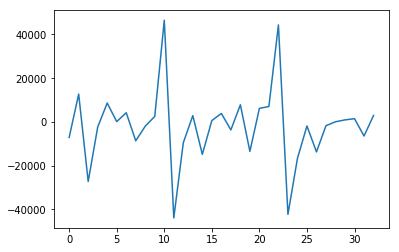

In [44]:
ts_detrend = difference(ts)
plt.plot(ts_detrend)

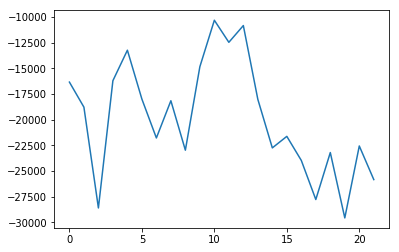

In [47]:
ts_deseason = difference(ts, 12)
plt.plot(ts_deseason)

Test the staionality ofter removing seasonality

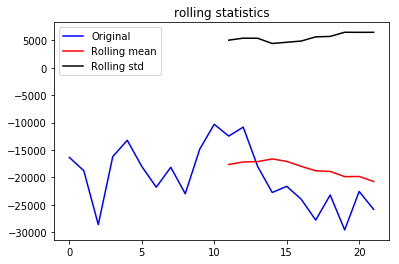

results of ADFC test
(-1.1941505456130461, 0.6761069241046854, 7, 14, {'1%': -4.01203360058309, '5%': -3.1041838775510207, '10%': -2.6909873469387753}, 235.82427724291784)
Test statistics                -1.194151
p-value                         0.676107
#lags Used                      7.000000
Number of observations Used    14.000000
Critical value (1%)            -4.012034
Critical value (5%)            -3.104184
Critical value (10%)           -2.690987
dtype: float64


In [51]:
test_stationary(ts_deseason)